# <center>Занятие 24. Прогноз просрочки кредита заемщиком</center>

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve, learning_curve
RANDOM_STATE = 17
import warnings
warnings.filterwarnings('ignore')

### Описание набора данных

Данные представляют собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit/data ). Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

Данная решаемая задача будет ценна как кредиторам, так и заемщикам для оценки способности вернуть долг вовремя.

### Описание признаков

* 1 - __SeriousDlqin2yrs__ - будет ли просрочка более 90 дней в ближайшие 2 года (целевая метка) (Да/Нет)
* 2 - __RevolvingUtilizationOfUnsecuredLines__ - общий баланс по кредитным картам и кредитным линиям, за исключением задолженностей по недвижимости задолженности по взносам, деленные на сумму кредитных лимитов (проценты)
* 3 - __age__ - Возраст заемщика (в годах)
* 4 - __NumberOfTime30-59DaysPastDueNotWorse__ - количество просрочек в 30-59 дней (Целое)
* 5 - __DebtRatio__ - коэффициент задолженности, т.е. сумма ежемесячных платежей по долгам, алиментов и расходов на проживание, деленная на месячный доналоговый доход (проценты)
* 6 - __Monthly Income__ - месячный доход (число с плавающей точкой)
* 7 - __NumberOfOpenCreditLinesAndLoans__ - количество открытых кредитов и кредитных линий (Целое)
* 8 - __NumberOfTimes90DaysLate__ - количество просрочек более 90 дней (Целое)
* 9 - __NumberRealEstateLoansOrLines__ - количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии домашнего капитала (Целое)
* 10 - __NumberOfTime60-89DaysPastDueNotWorse__ - количество просрочек в 60-89 дней за последние 2 года (Целое)
* 11 - __NumberOfDependents__ - количество иждивенцев в семье (исключая самих заемщиков) (Целое)

In [2]:
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

In [93]:
df = pd.read_csv('cs-training.csv', index_col=0)

In [4]:
feature_names = df.columns[1:]
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
print(df.shape)
df.describe(include = "all").T

(150000, 11)


,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [6]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

Проверьте наличие категориальных признаков, а также соответствие содержимого данных их типам

In [7]:
#NumberOfDependent (количество иждивенцев в семье) должно быть целым, а стоит число с плаввающей точкой
df['NumberOfDependents'].value_counts()

0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
10.0        5
9.0         5
20.0        1
13.0        1
Name: NumberOfDependents, dtype: int64

In [8]:
df['MonthlyIncome'].value_counts()

5000.0     2757
4000.0     2106
6000.0     1934
3000.0     1758
0.0        1634
           ... 
16084.0       1
10523.0       1
55250.0       1
9242.0        1
7647.0        1
Name: MonthlyIncome, Length: 13594, dtype: int64

In [9]:
# количество уникальных значений
df.nunique()

SeriousDlqin2yrs                             2
RevolvingUtilizationOfUnsecuredLines    125728
age                                         86
NumberOfTime30-59DaysPastDueNotWorse        16
DebtRatio                               114194
MonthlyIncome                            13594
NumberOfOpenCreditLinesAndLoans             58
NumberOfTimes90DaysLate                     19
NumberRealEstateLoansOrLines                28
NumberOfTime60-89DaysPastDueNotWorse        13
NumberOfDependents                          13
dtype: int64

Проверьте наличие NaN, при необходимости осуществите замену

О чем свидетельствуют пропуски в данных, чем их лучше заменить? Осуществите необходимую замену...

In [10]:
# пропуски заменим средним значением
df['MonthlyIncome']=df['MonthlyIncome'].fillna(df['MonthlyIncome'].median()).astype(float)

In [11]:
# преобразуем тип переменных
# пропуски заменяю на ноль, т.к.это большинство
df['NumberOfDependents']=df['NumberOfDependents'].fillna(0).astype(int)

In [12]:
# нулевой возраст быть не может, поэтому можем удалить это значение или заменить средним. Заменю средним
df['age'].value_counts()

49     3837
48     3806
50     3753
47     3719
63     3719
       ... 
102       3
109       2
107       1
105       1
0         1
Name: age, Length: 86, dtype: int64

In [13]:
#if df['age'] == 0:
   # df['age']=df['age'].fillna(df['age'].median())

In [14]:
df=df[(df['age']!=0)]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149999 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149999 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149999 non-null  float64
 2   age                                   149999 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149999 non-null  int64  
 4   DebtRatio                             149999 non-null  float64
 5   MonthlyIncome                         149999 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149999 non-null  int64  
 7   NumberOfTimes90DaysLate               149999 non-null  int64  
 8   NumberRealEstateLoansOrLines          149999 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149999 non-null  int64  
 10  NumberOfDependents                    149999 non-null  int32  
dtype

Оцените количество вернувших и не вернувших кредит. Какую метрику лучше всего использовать?

In [16]:
df['SeriousDlqin2yrs'].value_counts()

0    139973
1     10026
Name: SeriousDlqin2yrs, dtype: int64

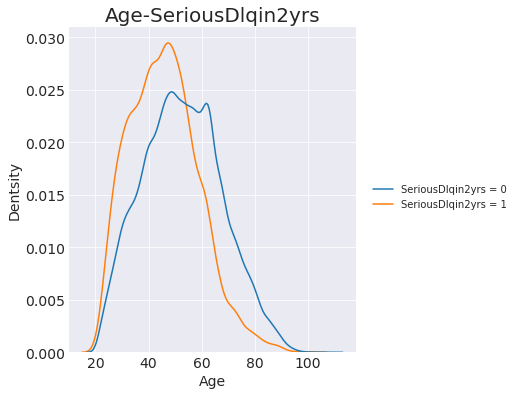

In [17]:
sns.displot(
    {
        "SeriousDlqin2yrs = 0": df[df.SeriousDlqin2yrs == 0].age,
        "SeriousDlqin2yrs = 1": df[df.SeriousDlqin2yrs == 1].age,
       
    },
    kind="kde",
    common_norm=False
)

plt.title('Age-SeriousDlqin2yrs', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Проверьте качество замены переменных

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,149999.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,149999.0,6.048472,249.756203,0.0,0.029867,0.154176,0.559044,50708.0
age,149999.0,52.295555,14.771298,21.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149999.0,0.421029,4.192795,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,149999.0,353.007426,2037.825113,0.0,0.175074,0.366503,0.868257,329664.0
MonthlyIncome,149999.0,6418.457710,12890.438465,0.0,3903.000000,5400.000000,7400.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,149999.0,8.452776,5.145964,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,149999.0,0.265975,4.169318,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,149999.0,1.018233,1.129772,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149999.0,0.240388,4.155193,0.0,0.000000,0.000000,0.000000,98.0


__Визуализация данных__

Используя  seaborn.pairplot (sns) визуализируйте данные

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

In [94]:
df_1=df.copy()

In [21]:
random_splitter= StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=42)
for train_index, test_index in random_splitter.split(df,df.SeriousDlqin2yrs):
    df =df.iloc[test_index]

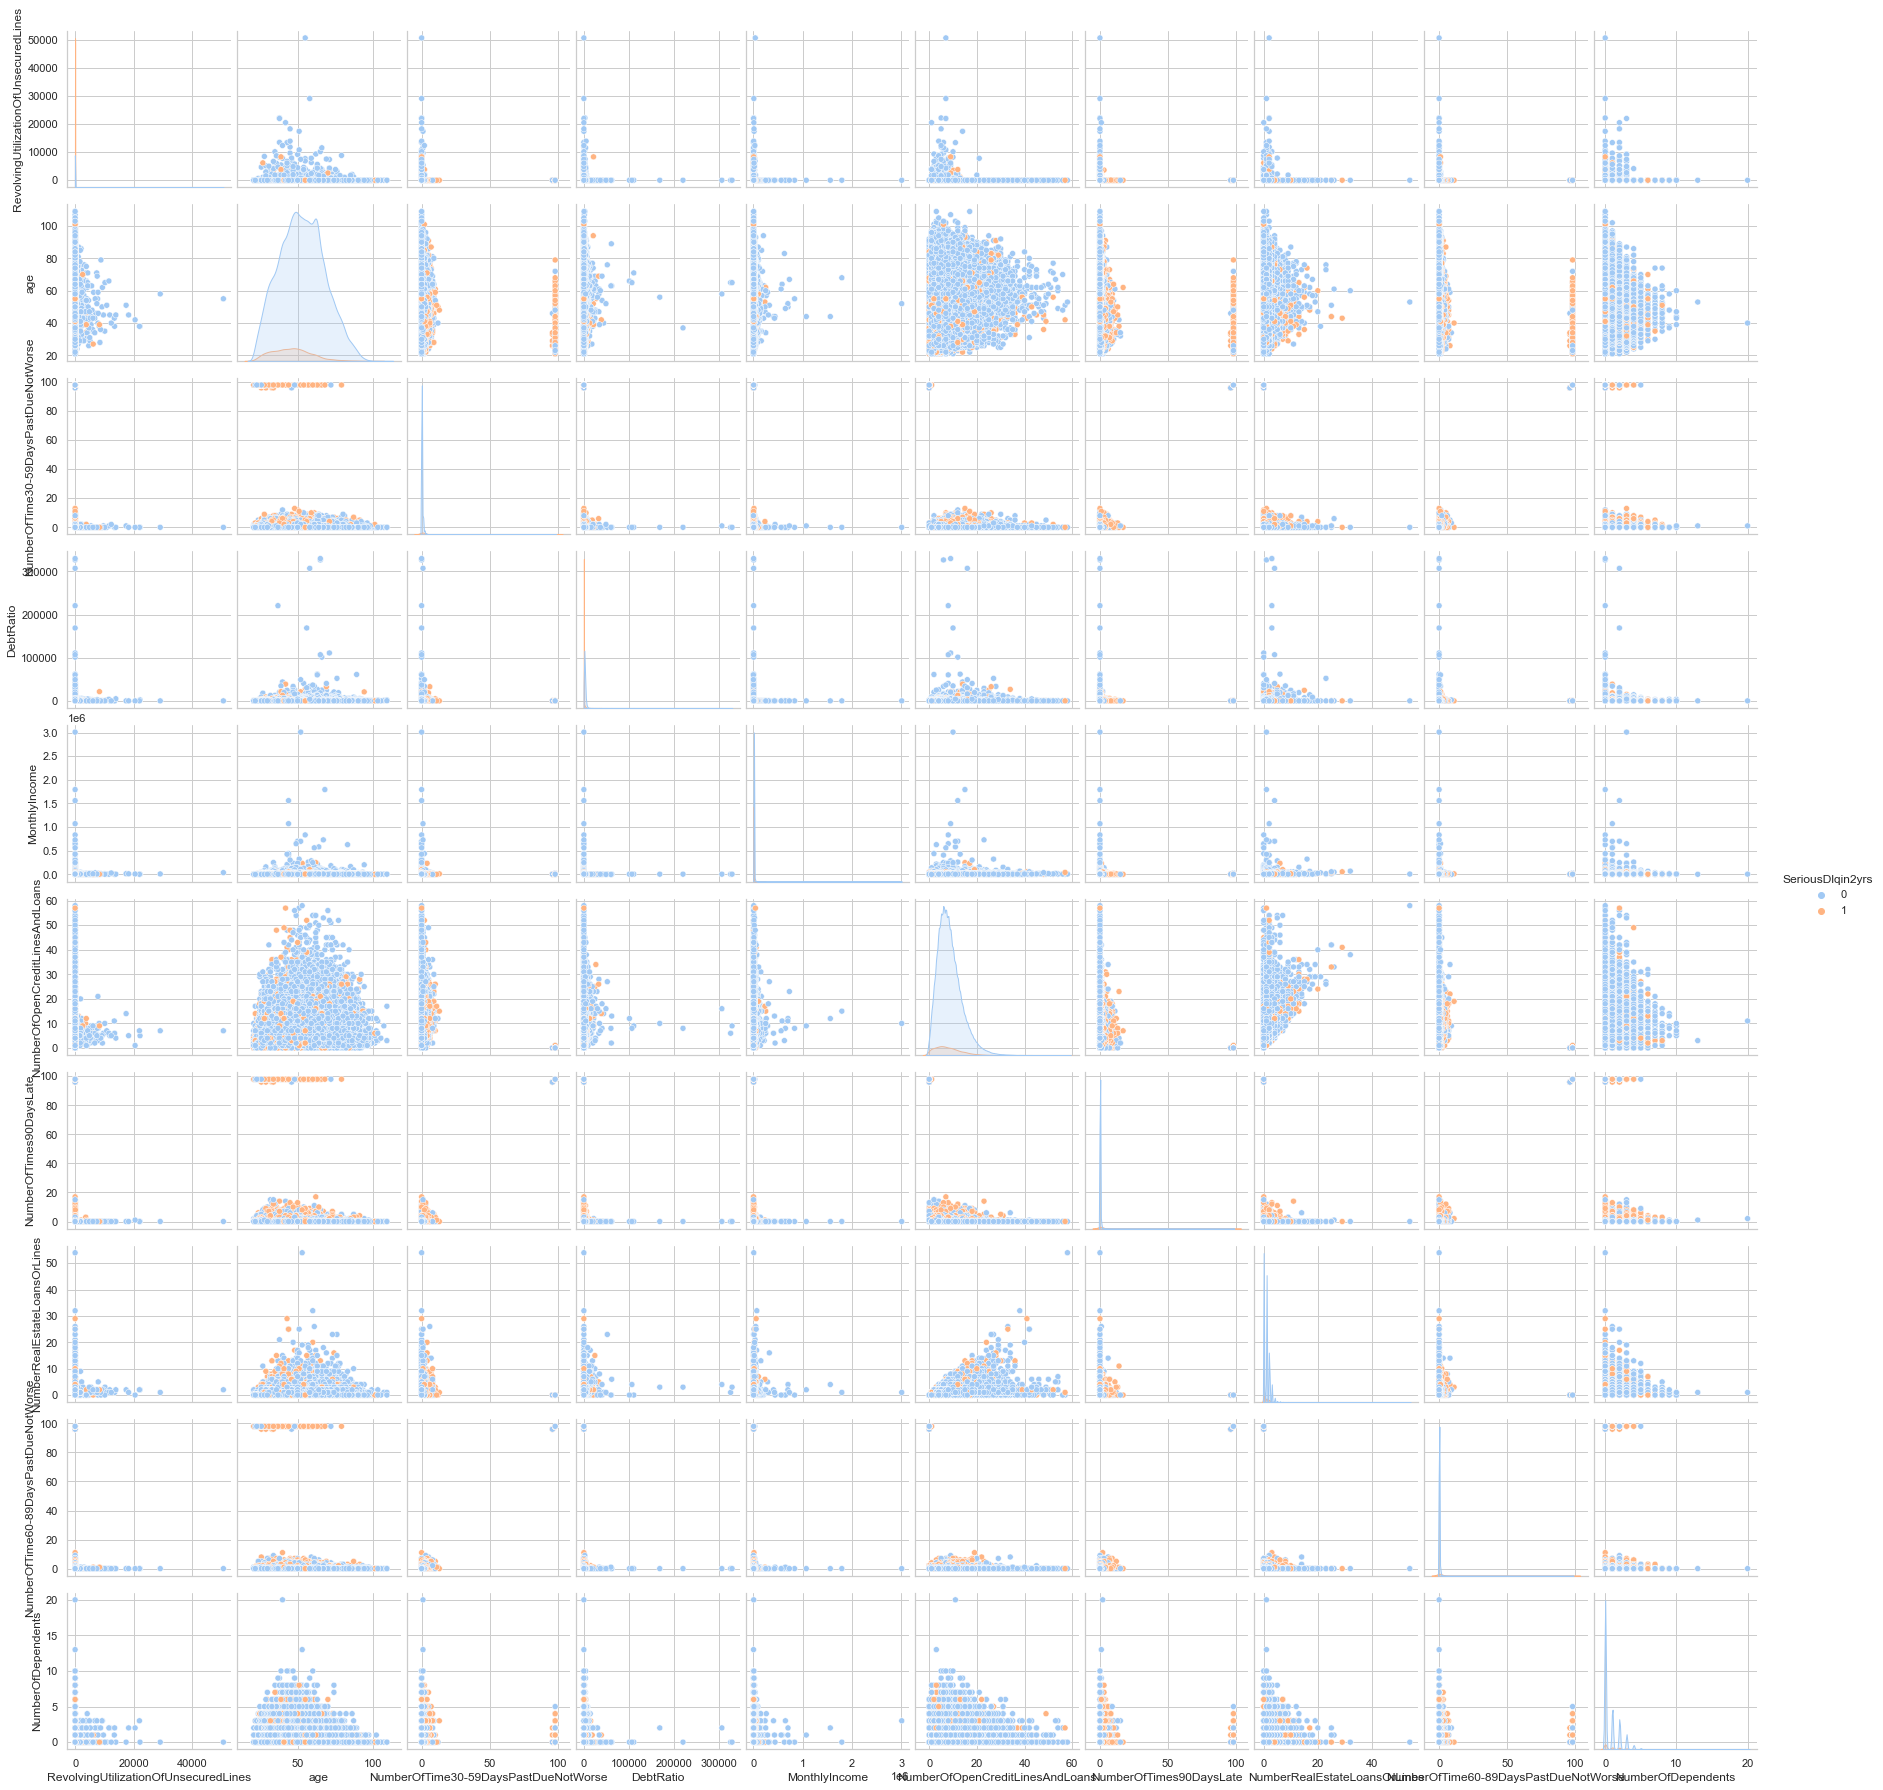

In [22]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.pairplot(df_1, hue="SeriousDlqin2yrs")

Используя sns.heatmap постройте корреляционную матрицу

<AxesSubplot:title={'center':'Корреляционная матрица'}>

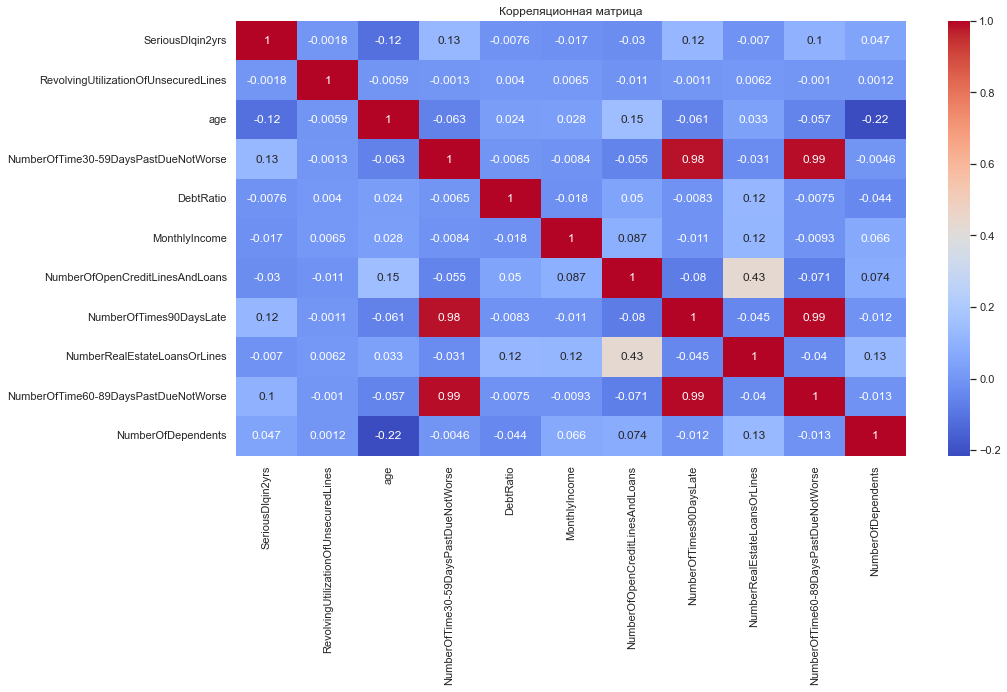

In [23]:
plt.figure(figsize=(15,8))
plt.title("Корреляционная матрица")
sns.heatmap(df_1.corr(), annot=True, cmap='coolwarm')


Какие существуют зависимости в данных?
Опишите зависимости каждого из признаков!

Очень большая корhеляция NumberOfTime30-59DaysPastDueNotWorse (количество просрочек в 30-59 дней) с
NumberOfTimes90DaysLate (количество просрочек более 90 дней) и NumberOfTime60-89DaysPastDueNotWorse (количество просрочек в 60-89 дней за последние 2 года). Поэтому мне кажется, что лучше объединить все виды просрочки в один столбец.


__Предобработка данных__

Оцените распределение признаков. Удалите коррелированные! Выберите способ нормализации. Подготовьте данные для обучения выбранных моделей...

In [95]:
df_1['DaysPastDue>30'] = df_1['NumberOfTime30-59DaysPastDueNotWorse']+ df_1['NumberOfTimes90DaysLate']+ df_1['NumberOfTime60-89DaysPastDueNotWorse']


In [96]:
df_1=df_1.drop(['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse'], axis=1)


<AxesSubplot:title={'center':'Корреляционная матрица'}>

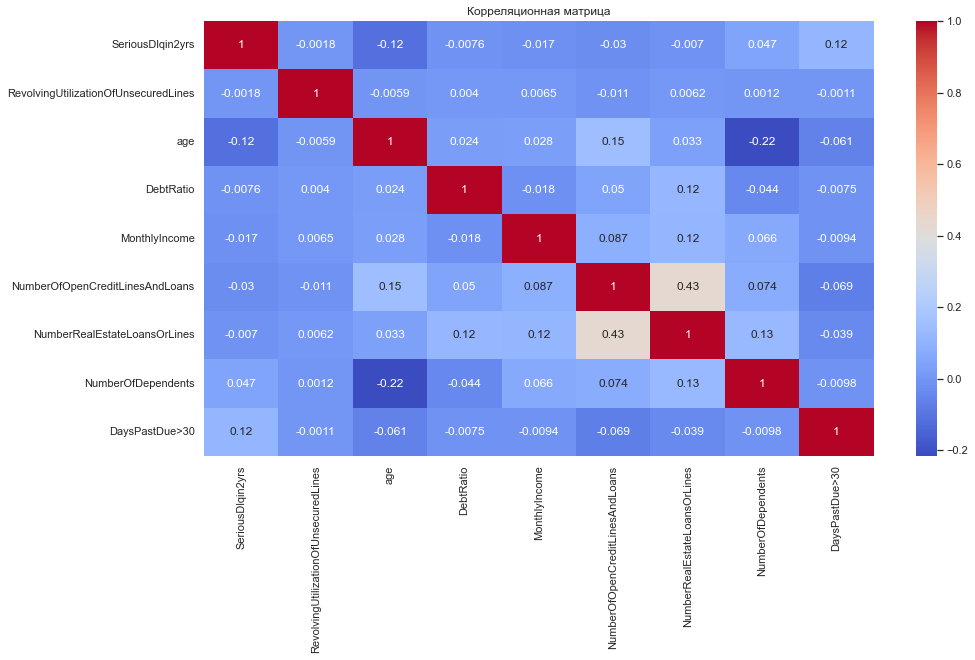

In [26]:
plt.figure(figsize=(15,8))
plt.title("Корреляционная матрица")
sns.heatmap(df_1.corr(), annot=True, cmap='coolwarm')

* NumberRealEstateLoansOrLines (количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии домашнего капитала) коррелирует с NumberOfOpenCreditLinesAndLoans (количество открытых кредитов и кредитных линий)

* age (возраст) коррелирует c NumberOfDependents (количество иждивенцев в семье (исключая самих заемщиков))

In [87]:
y = df_1['SeriousDlqin2yrs']
X = df_1.drop(['SeriousDlqin2yrs'], axis=1)

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=42)

In [90]:
ss=StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

__Выбор метрики__

В качестве метрики используется ROC-AUC score, согласно соренованию. Данная метрика подходит для данной задачи, так как мы хотим определять тех заемщиков, которые сильно задержат выплату кредита, но при этом выдавать кредиты хорошим клиентам. Также эта метрика хорошо работает со случаем несбалансированных классов (как в нашем случае).
Выберите способ перекрестной проверки! Какой из них подходит наилучшим образом...

In [97]:
forest = RandomForestClassifier(n_estimators=800, max_depth=20, 
                                random_state=2020, n_jobs=-1)

In [100]:
from sklearn.metrics import roc_auc_score
forest.fit(X_train, y_train);
print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])))

AUC на обучающей выборке: 1.000
AUC на контрольной выборке: 0.836


In [99]:
from sklearn.metrics import roc_auc_score
forest.fit(X_train, y_train);
print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, forest.predict_proba(X_train_scaled)[:, 1])))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, forest.predict_proba(X_test_scaled)[:, 1])))

AUC на обучающей выборке: 0.604
AUC на контрольной выборке: 0.763


Обучите 2 классификатора логистическую регрессию и случайный лес.
Для визуализации процесса обучения используйте прогрессбар tqdm

In [35]:
from sklearn.linear_model import LinearRegression

In [101]:
LR = LogisticRegression(max_iter=1000)                            
LR.fit(X_train, y_train);
print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, LR.predict_proba(X_train)[:, 1])))
print('AUC на тестовой выборке: {:.3f}'.
      format(roc_auc_score(y_test, LR.predict_proba(X_test)[:, 1])))

AUC на обучающей выборке: 0.851
AUC на тестовой выборке: 0.765


In [102]:
LR = LogisticRegression(max_iter=1000)                            
LR.fit(X_train, y_train);
print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, LR.predict_proba(X_train_scaled)[:, 1])))
print('AUC на тестовой выборке: {:.3f}'.
      format(roc_auc_score(y_test, LR.predict_proba(X_test_scaled)[:, 1])))

AUC на обучающей выборке: 0.632
AUC на тестовой выборке: 0.738


Оцените среднюю правильность выбранной модели

### Прогрессбар tqdm не поняла

In [56]:

#from tqdm import tqdm
#from tqdm.notebook import tqdm
#tqdm.pandas()

In [39]:
import time

In [43]:
parametrs = {'max_depth': range (2, 22, 5),'max_features': ['sqrt','log2', None]}

start = time.time()
Forest_gridsearch = GridSearchCV(forest,parametrs, verbose=2).fit(X_train,y_train)


print ("Подбор параметров произведен за ", time.time()-start, ' секунд.')
print('Лучшие параметры для модели : {}'.format(Forest_gridsearch.best_params_))
print('Средний перекрестно подтвержденный балл : {:.3f}\n'.format(Forest_gridsearch.best_score_))



Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................max_depth=2, max_features=sqrt; total time=  13.5s
[CV] END .....................max_depth=2, max_features=sqrt; total time=  11.0s
[CV] END .....................max_depth=2, max_features=sqrt; total time=  10.8s
[CV] END .....................max_depth=2, max_features=sqrt; total time=  11.4s
[CV] END .....................max_depth=2, max_features=sqrt; total time=  10.5s
[CV] END .....................max_depth=2, max_features=log2; total time=  12.2s
[CV] END .....................max_depth=2, max_features=log2; total time=  11.0s
[CV] END .....................max_depth=2, max_features=log2; total time=  11.6s
[CV] END .....................max_depth=2, max_features=log2; total time=  12.0s
[CV] END .....................max_depth=2, max_features=log2; total time=  12.7s
[CV] END .....................max_depth=2, max_features=None; total time=  23.5s
[CV] END .....................max_depth=2, max_f

In [44]:
print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train,Forest_gridsearch.predict(X_train))))


AUC на обучающей выборке: 0.633


In [74]:
TestResults = pd.DataFrame(Forest_gridsearch.cv_results_) 

<AxesSubplot:xlabel='param_max_depth', ylabel='mean_test_score'>

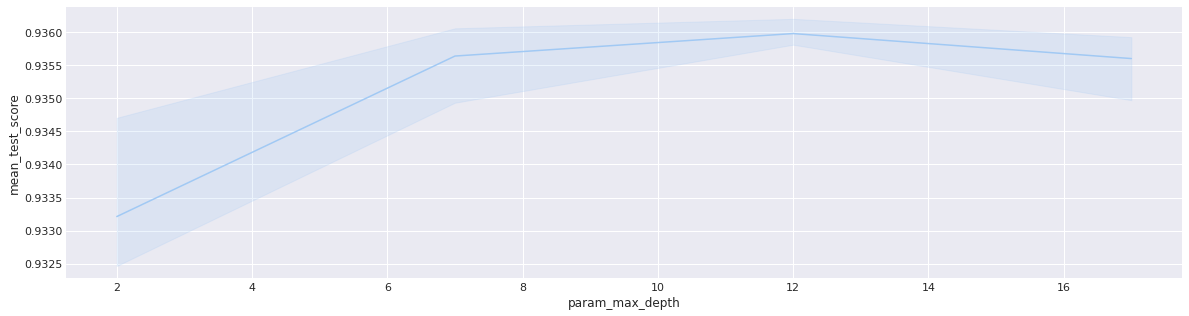

In [75]:
plt.figure(figsize=(20,5))
sns.lineplot (x=TestResults['param_max_depth'], y=TestResults['mean_test_score'])

<AxesSubplot:xlabel='param_max_features', ylabel='mean_test_score'>

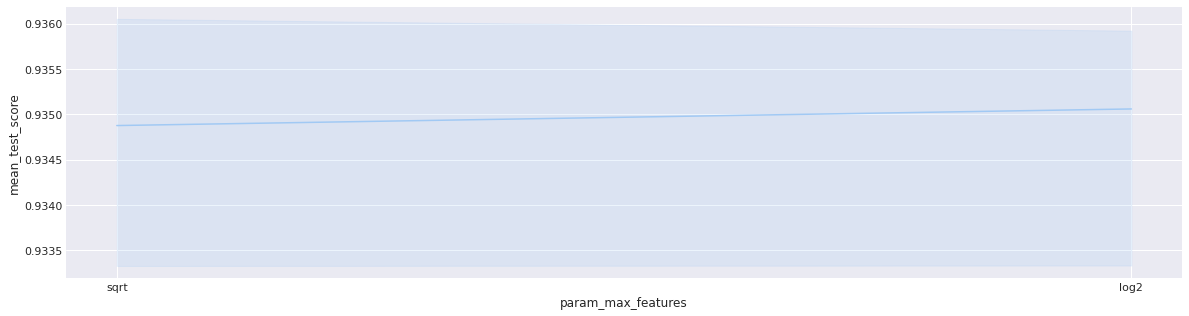

In [77]:
plt.figure(figsize=(20,5))
sns.lineplot (x=TestResults['param_max_features'], y=TestResults['mean_test_score'])

In [103]:
parametrs ={'C':[0.001, 0.01, 0.05, 0.1, 1.0, 5, 10.0]}

start = time.time()

LR_gridsearch = GridSearchCV(LR, param_grid=parametrs, verbose=2)
LR_gridsearch.fit(X_train,y_train)

print ("Подбор параметров произведен за ", time.time()-start, ' секунд.')
print('Лучшие параметры для модели : {}'.format(LR_gridsearch.best_params_))
print('Средний перекрестно подтвержденный балл  : {:.3f}\n'.format(LR_gridsearch.best_score_))


Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.05; total time=   0.0s
[CV] END ........................................

In [104]:
print('AUC на обучающей выборке: {:.3f}'.
    format(roc_auc_score(y_train, LR_gridsearch.predict(X_train))))

AUC на обучающей выборке: 0.597


In [105]:
TestResults = pd.DataFrame(LR_gridsearch.cv_results_) 

<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

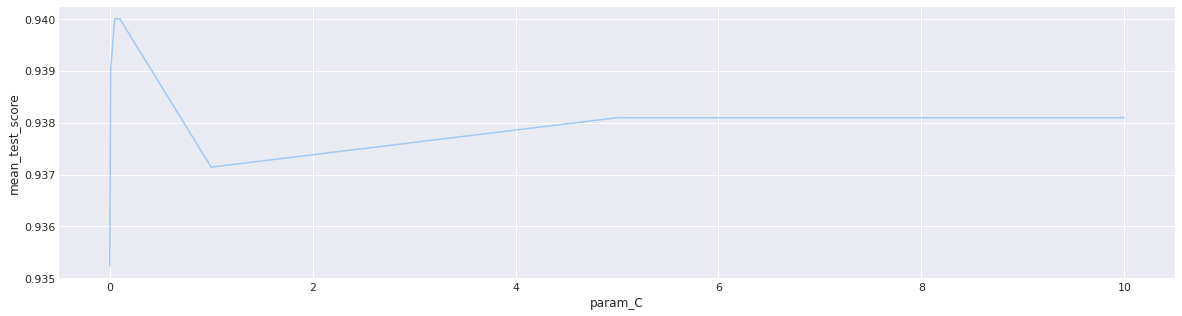

In [106]:
plt.figure(figsize=(20,5))
sns.lineplot (x=TestResults['param_C'], y=TestResults['mean_test_score'])

Отобразите результаты обучения модели

In [107]:
Forest_gridsearch.score (X_test, y_test)

0.9466666666666667

In [108]:
LR_gridsearch.score (X_test, y_test)

0.9288888888888889

Какая из моделей показала наилучшие результаты? Отобразите подобранные параметры.

### RandomForestClassifier

* Подбор параметров произведен за  2164.0726313591003  секунд.
* Лучшие параметры для модели : {'max_depth': 12, 'max_features': 'sqrt'}
* Средний перекрестно подтвержденный балл : 0.936
* AUC на обучающей выборке: 0.633


### LogisticRegression
1 попытка
* Подбор параметров произведен за  51.49860072135925  секунд.
* лучшие параметры для модели : {'C': 10.0}
* Средний перекрестно подтвержденный балл  : 0.933
* AUC на обучающей выборке: 0.507

2 попытка
* Подбор параметров произведен за  3.380030870437622  секунд.
* Лучшие параметры для модели : {'C': 0.05}
* Средний перекрестно подтвержденный балл  : 0.940
* AUC на обучающей выборке: 0.597

__Создание новых признаков__

1. Выберите признаки подлежащие бинаризации.
2. Осуществите бинаризацию.
3. Как влияет количество интервалов бинаризации на качество модели? 

Для создания новых признаков рекомендую ответить на следующие вопросы:
Как влияют количество иждевенцев у заемщика на просрочку выплат?
Какой тип кредитов чаще всего берет заемщик?

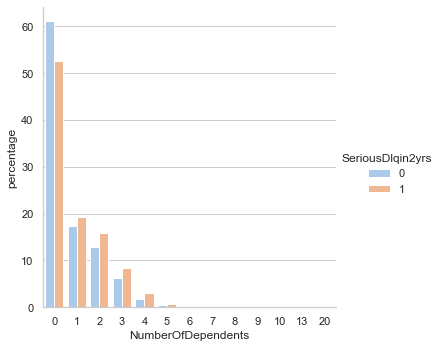

In [49]:
SD_num_dep = (df_1.groupby(['SeriousDlqin2yrs'])['NumberOfDependents']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('NumberOfDependents'))

ax = sns.catplot(x="NumberOfDependents", y="percentage", hue="SeriousDlqin2yrs", data=SD_num_dep, kind='bar')

Очень сильно заметно влияние количества иждевенцов на результат

### Очень плохо поняла эту часть задачи

### Нашла такой вариант бинаризации, но неуверена, что он правильный
https://nagornyy.me/it/rabota-s-priznakami-kak-chast-mashinnogo-obucheniia/

In [50]:
col = "NumberOfDependents"
cumsum = df_1.groupby("NumberOfDependents")["SeriousDlqin2yrs"].cumsum() - df_1["SeriousDlqin2yrs"]
cumcount = df_1.groupby("NumberOfDependents").cumcount()
df_1["cumsum"] = cumsum #Возвращает совокупную сумму по оси DataFrame 
df_1["cumcount"] = cumcount #Пронумеруйте каждый элемент в каждой группе от 0 до длины этой группы - 1.
df_1["NumberOfDependents_mean_target"] = cumsum/cumcount
df_1[["NumberOfDependents", "cumsum", "cumcount", "NumberOfDependents_mean_target", "SeriousDlqin2yrs"]].head(5)

,NumberOfDependents,cumsum,cumcount,NumberOfDependents_mean_target,SeriousDlqin2yrs
1,2,0,0,NaN,1
2,1,0,0,NaN,0
3,0,0,0,NaN,0
4,0,0,1,0.0,0
5,0,0,2,0.0,0


In [51]:
df_1

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,DaysPastDue>30,cumsum,cumcount,NumberOfDependents_mean_target
1,1,0.766127,45,0.802982,9120.0,13,6,2,2,0,0,NaN
2,0,0.957151,40,0.121876,2600.0,4,0,1,0,0,0,NaN
3,0,0.658180,38,0.085113,3042.0,2,0,0,2,0,0,NaN
4,0,0.233810,30,0.036050,3300.0,5,0,0,0,0,1,0.000000
5,0,0.907239,49,0.024926,63588.0,7,1,0,1,0,2,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0.225131,2100.0,4,1,0,0,5274,90822,0.058070
149997,0,0.299745,44,0.716562,5584.0,4,1,2,0,1584,19520,0.081148
149998,0,0.246044,58,3870.000000,5400.0,18,1,0,0,5274,90823,0.058069
149999,0,0.000000,30,0.000000,5716.0,4,0,0,0,5274,90824,0.058068


<AxesSubplot:title={'center':'Корреляционная матрица'}>

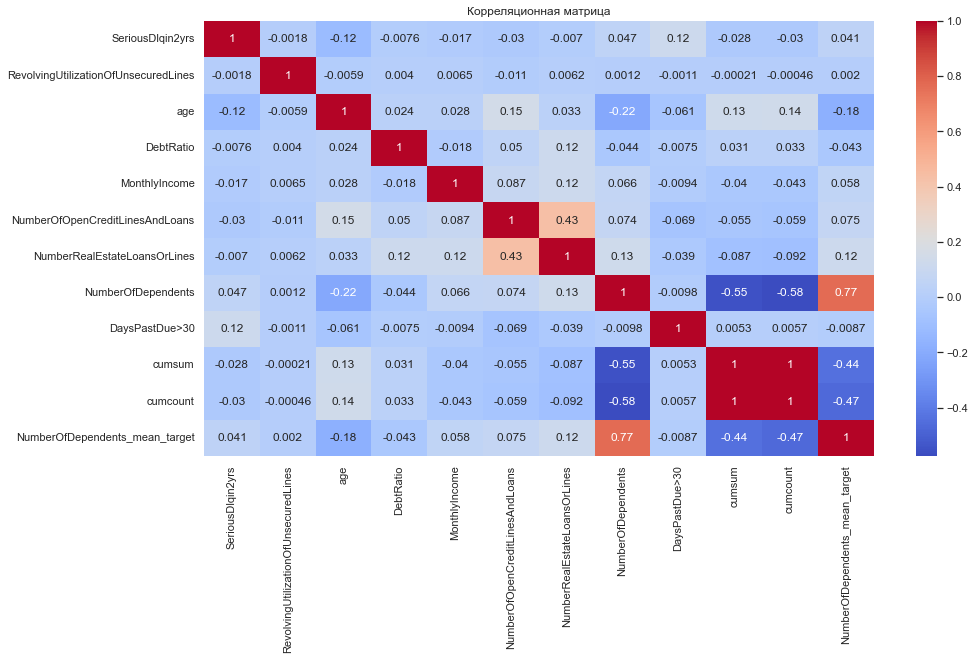

In [52]:
plt.figure(figsize=(15,8))
plt.title("Корреляционная матрица")
sns.heatmap(df_1.corr(), annot=True, cmap='coolwarm')

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [54]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7]


In [55]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)


clf.fit(X_train, y_train, 
        #cat_features=cat_features, 
        eval_set=(X_val, y_val), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'learning_rate': 0.1}


In [58]:
clf.fit(
    X_train, y_train,
    eval_set=(X_val, y_val)
)

0:	learn: 0.3914417	test: 0.3918413	best: 0.3918413 (0)	total: 11.3ms	remaining: 553ms
1:	learn: 0.2827573	test: 0.2838348	best: 0.2838348 (1)	total: 21.5ms	remaining: 517ms
2:	learn: 0.2322888	test: 0.2339440	best: 0.2339440 (2)	total: 34.4ms	remaining: 539ms
3:	learn: 0.2066247	test: 0.2089357	best: 0.2089357 (3)	total: 46.6ms	remaining: 536ms
4:	learn: 0.1944193	test: 0.1967315	best: 0.1967315 (4)	total: 58.7ms	remaining: 528ms
5:	learn: 0.1869928	test: 0.1897215	best: 0.1897215 (5)	total: 70.5ms	remaining: 517ms
6:	learn: 0.1830790	test: 0.1856814	best: 0.1856814 (6)	total: 81.7ms	remaining: 502ms
7:	learn: 0.1809921	test: 0.1836620	best: 0.1836620 (7)	total: 94ms	remaining: 494ms
8:	learn: 0.1795032	test: 0.1823273	best: 0.1823273 (8)	total: 105ms	remaining: 480ms
9:	learn: 0.1788072	test: 0.1817590	best: 0.1817590 (9)	total: 116ms	remaining: 465ms
10:	learn: 0.1783834	test: 0.1815891	best: 0.1815891 (10)	total: 128ms	remaining: 452ms
11:	learn: 0.1777156	test: 0.1812002	best: 0.1

### Catboost вообще плохо поняла.

__Кривые валидации и обучения__

In [ ]:
# Постройте кривые валидации и обучения

Какие наилучшие параметры модели по результатам построения?
Как можно улучшить модель?

In [ ]:
# Описание здесь

__Оценка модели с описанием выбранной метрики__

__Общие выводы__

По результатам проведенного анализа, можно увидеть, что есть определенные зависимости и признаки просрочки кредита. 
* Наблюдаются следующие закономерности - количество просрочек вне зависимости от дней коррелируют друг с другом.
* NumberRealEstateLoansOrLines (количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии домашнего капитала) коррелирует с NumberOfOpenCreditLinesAndLoans (количество открытых кредитов и кредитных линий)
* age (возраст) коррелирует c NumberOfDependents (количество иждивенцев в семье (исключая самих заемщиков))
* С ростом количества иждевенцев в семье заемщик становиться менее привлекательным в связи с высокой вероятностью новой просрочки.

* Также влияет и количество просрочек заемщика - клиент вероятнее не выплачивает кредит вовремя. 
